In [ ]:
import pandas as pd

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error


In [ ]:
df_train = pd.read_csv('DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('DailyDelhiClimateTest.csv')

In [ ]:
df_test.loc[0, 'meanpressure'] = df_test['meanpressure'].mean()

In [ ]:
df_train

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [ ]:
df_test

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,1004.035090
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


In [ ]:
def custom_df(df: pd.DataFrame, target_column: str, feature_columns: list, time_steps = 1) -> np.array:
    df_temp = df

    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler_target = MinMaxScaler(feature_range=(0, 1))

    scaled_features = scaler_features.fit_transform(df_temp[feature_columns])
    scaled_target = scaler_target.fit_transform(df_temp[[target_column]])
    scaled_data = np.concatenate((scaled_features, scaled_target), axis=1)

    X_temp, y_temp = [], []
    for i in range(len(scaled_data) - time_steps):
        X_temp.append(scaled_data[i:(i + time_steps),: -1])
        y_temp.append(scaled_data[i + time_steps, -1])
    y_temp = y_temp[1:]
    X_temp = X_temp[:-1]
    return np.array(X_temp), np.array(y_temp), scaler_target


In [ ]:
def create_lag_1(df: pd.DataFrame, feature: str) -> pd.DataFrame :
    df_t = df.copy()
    df_t['lag1'] = df_t[feature].diff()
    df_t = df_t.shift(-1)
    df_t = df_t.dropna()
    return df_t

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): # средняя абсолютная ошибка в процентах
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

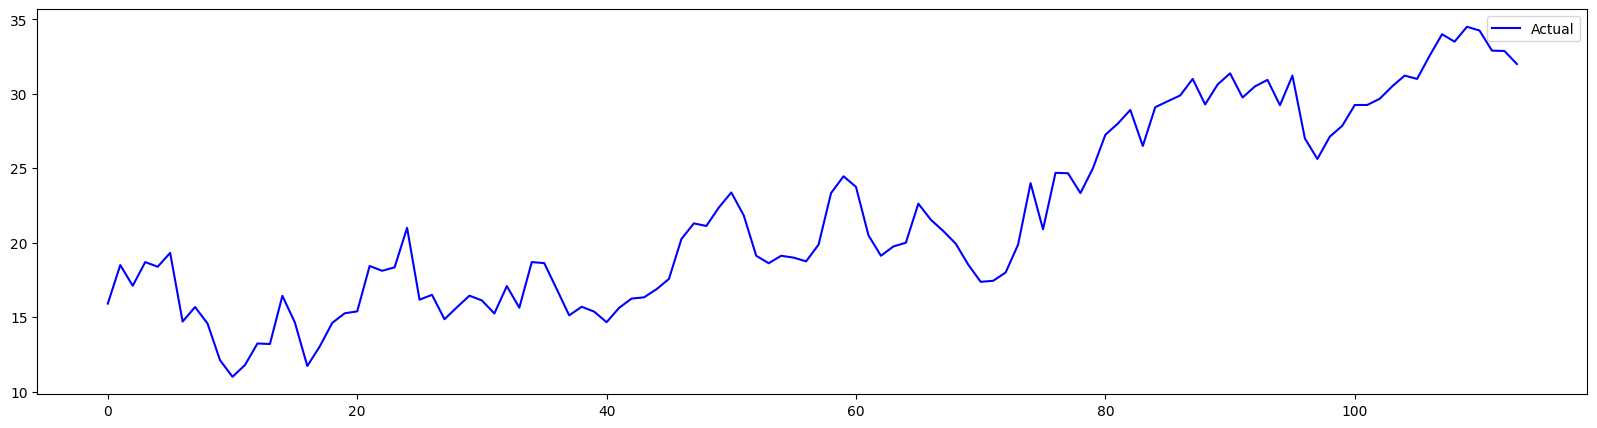

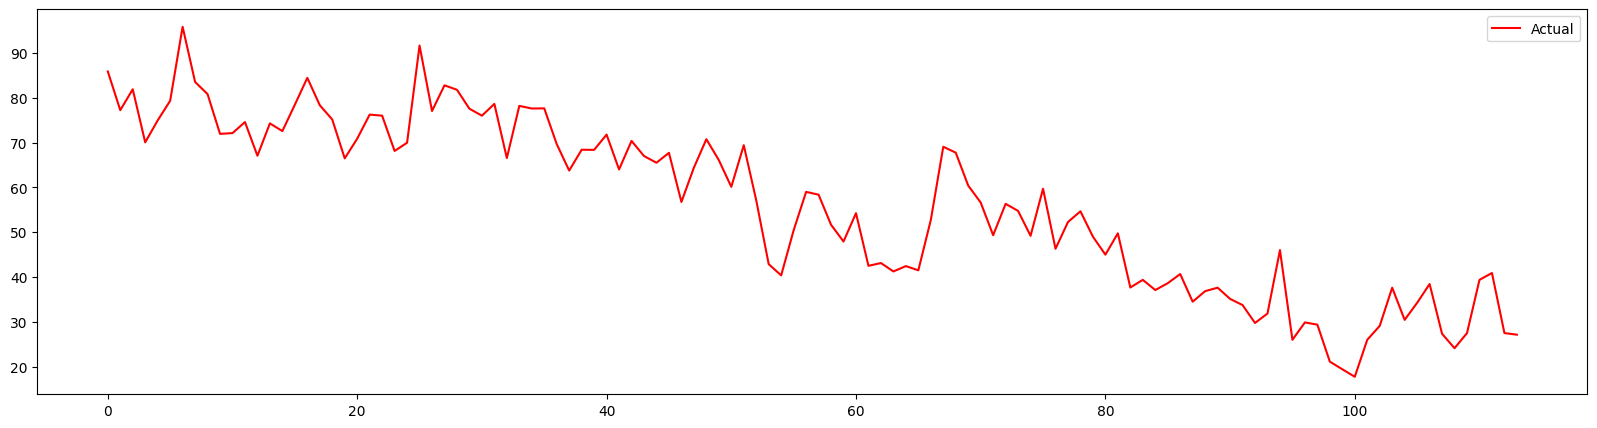

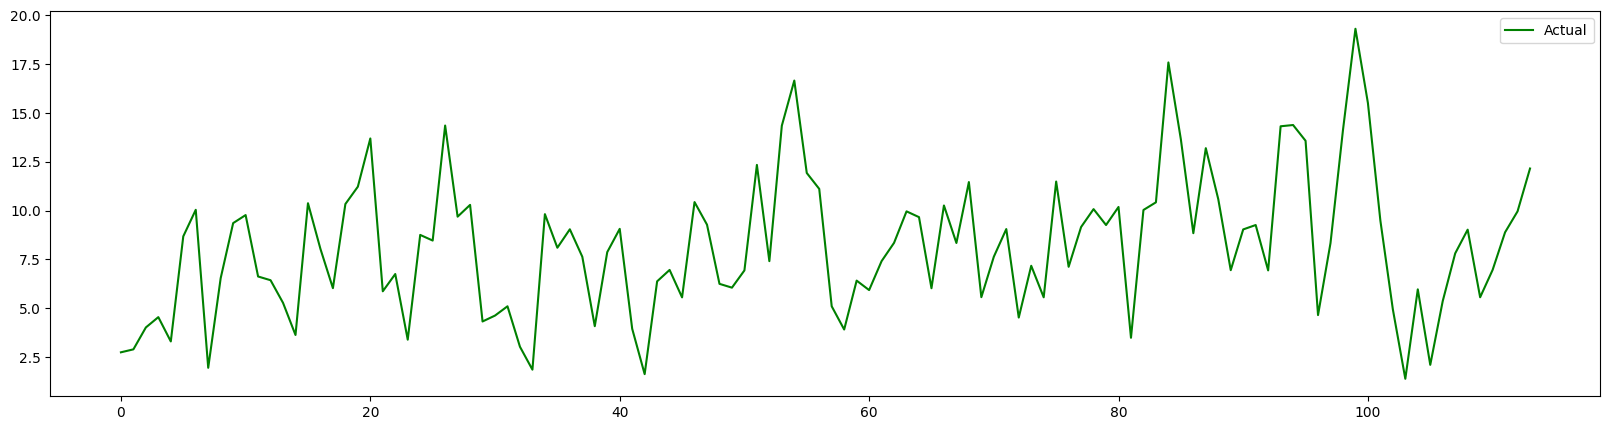

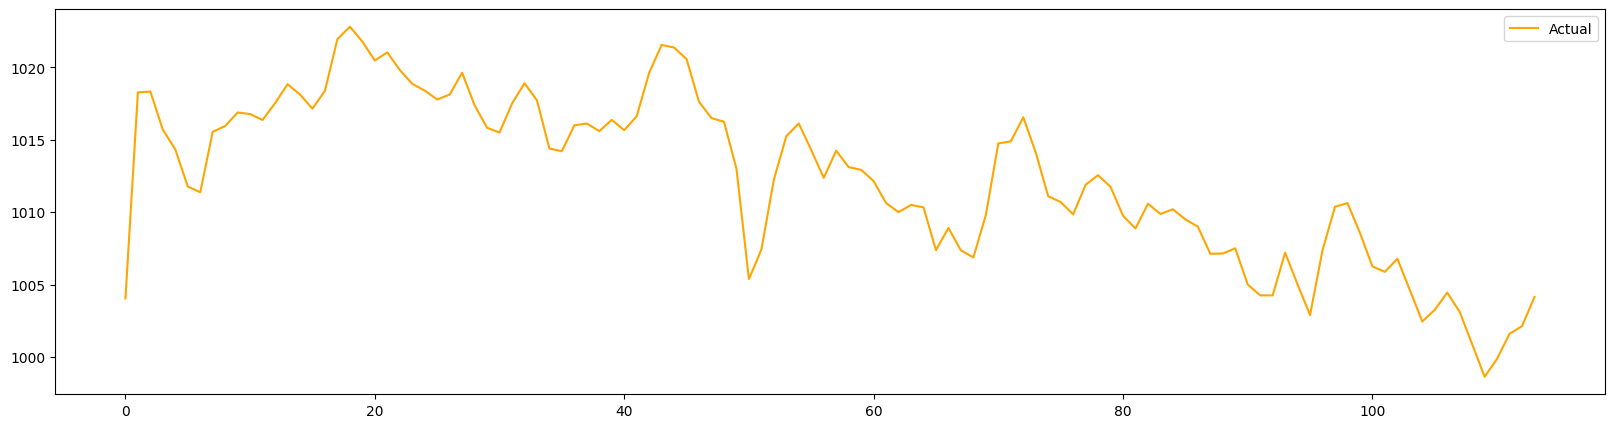

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,5))
plt.plot(df_test['meantemp'], label='Actual', color = 'blue' )
plt.legend()
plt.show()

plt.figure(figsize = (20,5))
plt.plot(df_test['humidity'], label='Actual', color = 'red' )
plt.legend()
plt.show()

plt.figure(figsize = (20,5))
plt.plot(df_test['wind_speed'], label='Actual', color = 'green' )
plt.legend()
plt.show()

plt.figure(figsize = (20,5))
plt.plot(df_test['meanpressure'], label='Actual', color = 'orange' )
plt.legend()
plt.show()

### Meantemp(LSTM)

In [ ]:
df_train_meantemp = create_lag_1(df_train, 'meantemp')
df_test_meantemp = create_lag_1(df_test, 'meantemp')


In [ ]:
X_train, y_train, scaler_target_train  = custom_df(df_train_meantemp,
                             'meantemp',
                             ['humidity', 'wind_speed', 'meanpressure', 'lag1'],
                            time_steps = 5)

In [ ]:
X_test, y_test, scaler_target_test  = custom_df(df_test_meantemp,
                             'meantemp',
                             ['humidity', 'wind_speed', 'meanpressure', 'lag1'],
                            time_steps = 5)

In [ ]:
model = Sequential()
model.add(LSTM(75, return_sequences=True, input_shape=(5, 4)))
model.add(LSTM(75, activation='tanh', return_sequences=True))
model.add(LSTM(75, activation='tanh'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
46/46 [==============================] - 5s 33ms/step - loss: 0.1045 - val_loss: 0.0811
Epoch 2/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0374 - val_loss: 0.0708
Epoch 3/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0341 - val_loss: 0.1137
Epoch 4/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0343 - val_loss: 0.1061
Epoch 5/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0340 - val_loss: 0.1332
Epoch 6/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0340 - val_loss: 0.1258
Epoch 7/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0346 - val_loss: 0.1292
Epoch 8/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0339 - val_loss: 0.1428
Epoch 9/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0337 - val_loss: 0.1139
Epoch 10/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0340 - val_loss: 0.1166

In [ ]:
predictions = model.predict(X_test)

predictions_original = scaler_target_test .inverse_transform(predictions)
y_test_original = scaler_target_test .inverse_transform(y_test.reshape(-1, 1))

mape_rnn = mean_absolute_percentage_error(y_test_original, predictions_original)
mae_rnn = mean_absolute_error(y_test_original, predictions_original)
print(f"MAPE: {mape_rnn}%")
print(f"MAE: {mae_rnn}")

4/4 [==============================] - 1s 6ms/step
MAPE: 29.765533333579096%
MAE: 5.49426325020879


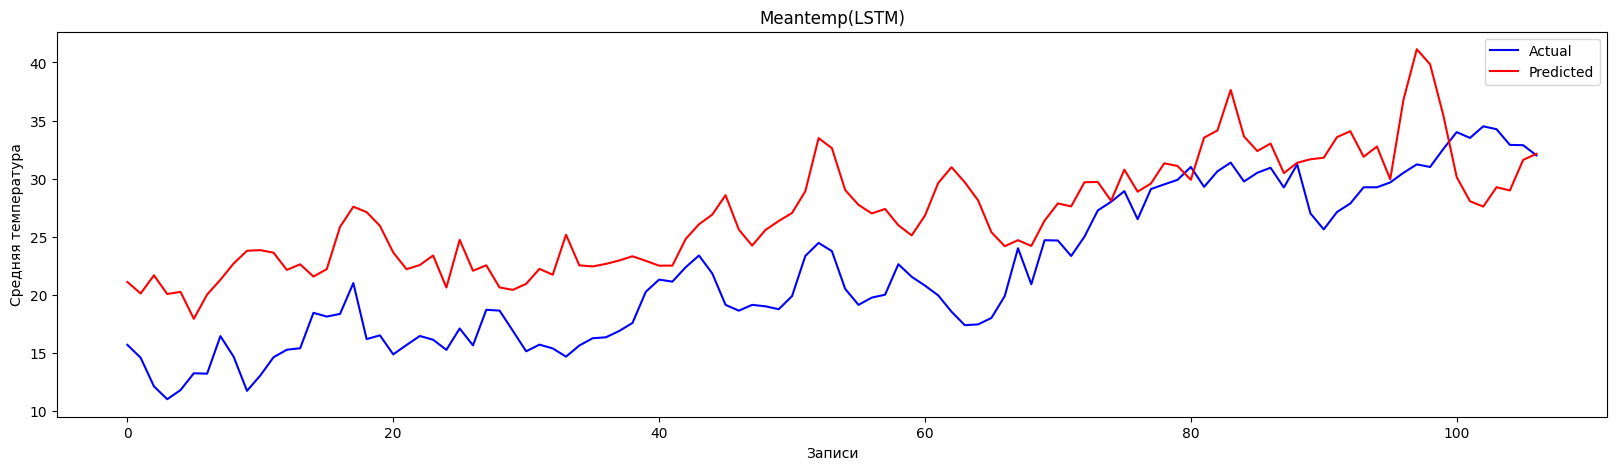

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(y_test_original, label='Actual', color = 'blue' )
plt.plot(predictions_original, label='Predicted', color = 'red')
plt.title('Meantemp(LSTM)')
plt.xlabel('Записи')
plt.ylabel('Средняя температура')
plt.legend()
plt.show()

### Humidity(LSTM)

In [ ]:
df_train_humidity = create_lag_1(df_train, 'humidity')
df_test_humidity = create_lag_1(df_test, 'humidity')

X_train, y_train, scaler_target_train  = custom_df(df_train_humidity,
                             'humidity',
                             ['meantemp', 'wind_speed', 'meanpressure', 'lag1'],
                            time_steps = 5)

X_test, y_test, scaler_target_test  = custom_df(df_test_humidity,
                             'humidity',
                             ['meantemp', 'wind_speed', 'meanpressure', 'lag1'],
                            time_steps = 5)

In [ ]:
model = Sequential()
model.add(LSTM(75, return_sequences=True, input_shape=(5, 4)))
model.add(LSTM(75, activation='tanh', return_sequences=True))
model.add(LSTM(75, activation='tanh'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
46/46 [==============================] - 4s 33ms/step - loss: 0.0804 - val_loss: 0.0548
Epoch 2/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0304 - val_loss: 0.0834
Epoch 3/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0300 - val_loss: 0.0611
Epoch 4/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0293 - val_loss: 0.0888
Epoch 5/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0292 - val_loss: 0.0691
Epoch 6/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0308 - val_loss: 0.0442
Epoch 7/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0290 - val_loss: 0.0436
Epoch 8/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0295 - val_loss: 0.0645
Epoch 9/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0293 - val_loss: 0.0473
Epoch 10/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0295 - val_loss: 0.0537

In [ ]:
predictions = model.predict(X_test)

predictions_original = scaler_target_test .inverse_transform(predictions)
y_test_original = scaler_target_test .inverse_transform(y_test.reshape(-1, 1))

mape_rnn = mean_absolute_percentage_error(y_test_original, predictions_original)
mae_rnn = mean_absolute_error(y_test_original, predictions_original)
print(f"MAPE: {mape_rnn}%")
print(f"MAE: {mae_rnn}")

4/4 [==============================] - 1s 5ms/step
MAPE: 23.036680100461826%
MAE: 9.745503471713628


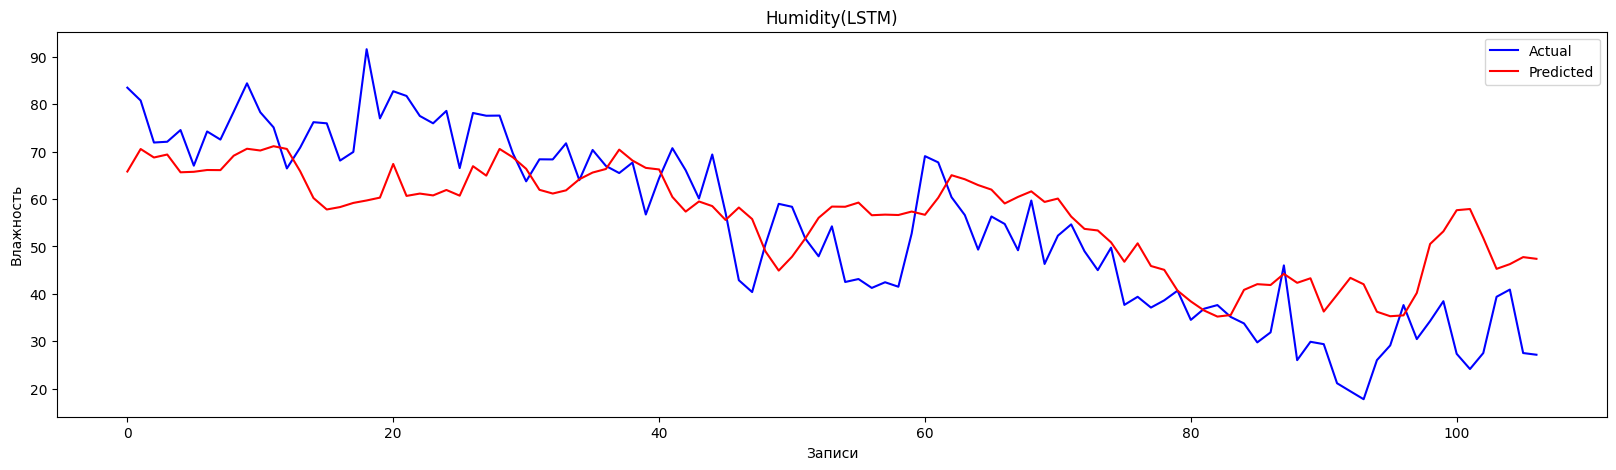

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(y_test_original, label='Actual', color = 'blue' )
plt.plot(predictions_original, label='Predicted', color = 'red')
plt.legend()
plt.title('Humidity(LSTM)')
plt.xlabel('Записи')
plt.ylabel('Влажность')
plt.show()

### Wind_speed(LSTM)

In [ ]:
df_train_wind_speed = create_lag_1(df_train, 'wind_speed')
df_test_wind_speed = create_lag_1(df_test, 'wind_speed')

X_train, y_train, scaler_target_train  = custom_df(df_train_wind_speed,
                             'wind_speed',
                             ['meantemp', 'humidity', 'meanpressure', 'lag1'],
                            time_steps = 5)

X_test, y_test, scaler_target_test  = custom_df(df_test_wind_speed,
                             'wind_speed',
                             ['meantemp', 'humidity', 'meanpressure', 'lag1'],
                            time_steps = 5)

In [ ]:
model = Sequential()
model.add(LSTM(75, return_sequences=True, input_shape=(5, 4)))
model.add(LSTM(75, activation='tanh', return_sequences=True))
model.add(LSTM(75, activation='tanh'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
46/46 [==============================] - 5s 34ms/step - loss: 0.0123 - val_loss: 0.0947
Epoch 2/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0112 - val_loss: 0.0881
Epoch 3/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0110 - val_loss: 0.0862
Epoch 4/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0108 - val_loss: 0.0782
Epoch 5/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0109 - val_loss: 0.0872
Epoch 6/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0109 - val_loss: 0.0887
Epoch 7/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0111 - val_loss: 0.0901
Epoch 8/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0109 - val_loss: 0.0921
Epoch 9/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0110 - val_loss: 0.0873
Epoch 10/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0109 - val_loss: 0.0946

In [ ]:
predictions = model.predict(X_test)

predictions_original = scaler_target_test .inverse_transform(predictions)
y_test_original = scaler_target_test .inverse_transform(y_test.reshape(-1, 1))

mape_rnn = mean_absolute_percentage_error(y_test_original, predictions_original)
mae_rnn = mean_absolute_error(y_test_original, predictions_original)
print(f"MAPE: {mape_rnn}%")
print(f"MAE: {mae_rnn}")

4/4 [==============================] - 1s 6ms/step
MAPE: 47.38761510969984%
MAE: 4.047144506697556


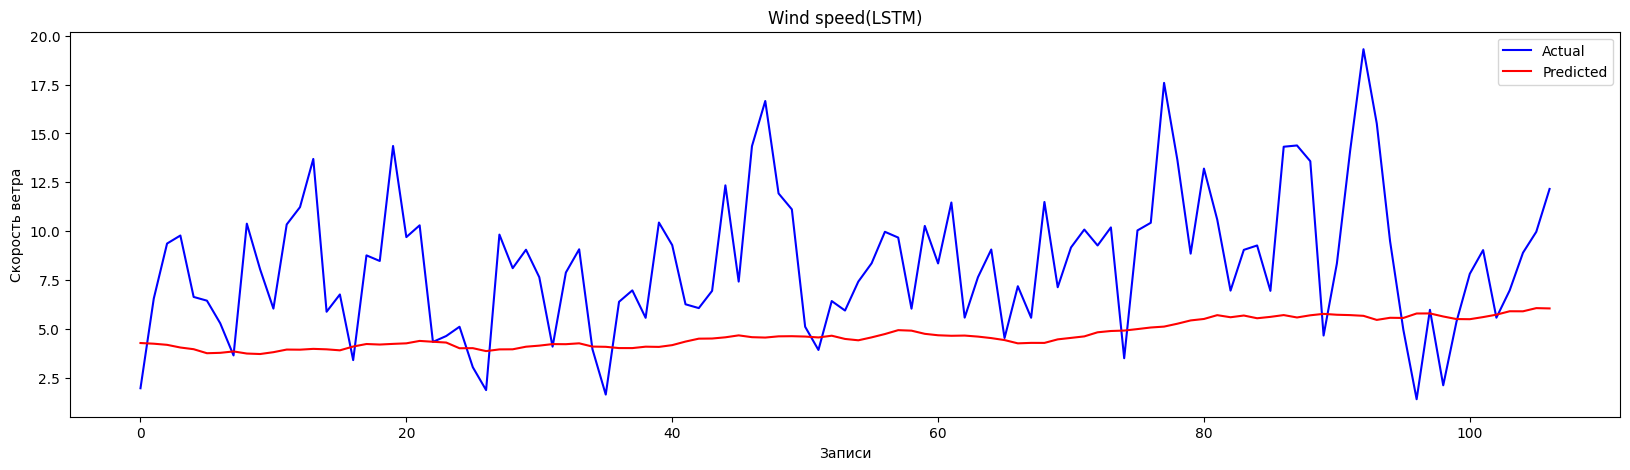

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(y_test_original, label='Actual', color = 'blue' )
plt.plot(predictions_original, label='Predicted', color = 'red')
plt.legend()
plt.title('Wind speed(LSTM)')
plt.xlabel('Записи')
plt.ylabel('Скорость ветра')
plt.show()

### Meanpressure(LSTM)

In [ ]:
df_train_meanpressure = create_lag_1(df_train, 'meanpressure')
df_test_meanpressure = create_lag_1(df_test, 'meanpressure')

X_train, y_train, scaler_target_train  = custom_df(df_train_meanpressure,
                             'meanpressure',
                             ['meantemp', 'humidity', 'wind_speed', 'lag1'],
                            time_steps = 5)

X_test, y_test, scaler_target_test  = custom_df(df_test_meanpressure,
                             'meanpressure',
                             ['meantemp', 'humidity', 'wind_speed', 'lag1'],
                            time_steps = 5)

In [ ]:
model = Sequential()
model.add(LSTM(75, return_sequences=True, input_shape=(5, 4)))
model.add(LSTM(75, activation='tanh', return_sequences=True))
model.add(LSTM(75, activation='tanh'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
46/46 [==============================] - 5s 34ms/step - loss: 0.0015 - val_loss: 0.2417
Epoch 2/100
46/46 [==============================] - 1s 14ms/step - loss: 6.1965e-04 - val_loss: 0.2523
Epoch 3/100
46/46 [==============================] - 1s 13ms/step - loss: 5.6578e-04 - val_loss: 0.2456
Epoch 4/100
46/46 [==============================] - 1s 14ms/step - loss: 5.6653e-04 - val_loss: 0.2466
Epoch 5/100
46/46 [==============================] - 1s 13ms/step - loss: 5.9381e-04 - val_loss: 0.2491
Epoch 6/100
46/46 [==============================] - 1s 13ms/step - loss: 5.6027e-04 - val_loss: 0.2467
Epoch 7/100
46/46 [==============================] - 1s 13ms/step - loss: 5.7009e-04 - val_loss: 0.2459
Epoch 8/100
46/46 [==============================] - 1s 13ms/step - loss: 5.7376e-04 - val_loss: 0.2516
Epoch 9/100
46/46 [==============================] - 1s 13ms/step - loss: 5.6794e-04 - val_loss: 0.2494
Epoch 10/100
46/46 [==============================] - 1s 13ms/step -

In [ ]:
predictions = model.predict(X_test)

predictions_original = scaler_target_test .inverse_transform(predictions)
y_test_original = scaler_target_test .inverse_transform(y_test.reshape(-1, 1))

mape_rnn = mean_absolute_percentage_error(y_test_original, predictions_original)
mae_rnn = mean_absolute_error(y_test_original, predictions_original)
print(f"MAPE: {mape_rnn}%")
print(f"MAE: {mae_rnn}")

4/4 [==============================] - 1s 7ms/step
MAPE: 1.0373606774675521%
MAE: 10.531660669850208


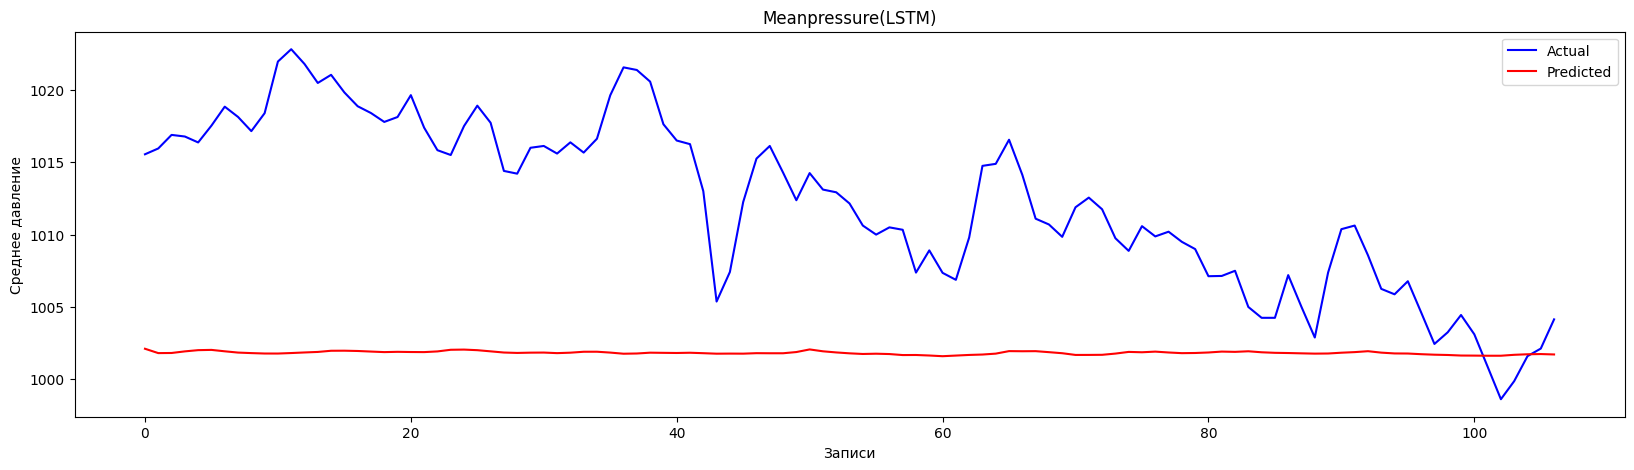

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(y_test_original, label='Actual', color = 'blue' )
plt.plot(predictions_original, label='Predicted', color = 'red')
plt.legend()
plt.title('Meanpressure(LSTM)')
plt.xlabel('Записи')
plt.ylabel('Среднее давление')
plt.show()

### Добавление механизма внимания

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AttentionMechanism(Layer):
    def __init__(self, return_sequences=True):
        super(AttentionMechanism, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x,self.W)+self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x*a

        if self.return_sequences:
            return output

        return tf.reduce_sum(output, axis=1)

#### Meantemp(LSTM)

In [ ]:
df_train_meantemp = create_lag_1(df_train, 'meantemp')
df_test_meantemp = create_lag_1(df_test, 'meantemp')

X_train, y_train, scaler_target_train  = custom_df(df_train_meantemp,
                             'meantemp',
                             ['humidity', 'wind_speed', 'meanpressure', 'lag1'],
                            time_steps = 5)

X_test, y_test, scaler_target_test  = custom_df(df_test_meantemp,
                             'meantemp',
                             ['humidity', 'wind_speed', 'meanpressure', 'lag1'],
                            time_steps = 5)

In [ ]:
model = Sequential()

model.add(LSTM(75, return_sequences=True, input_shape=(5, 4)))
model.add(LSTM(75, activation='tanh',return_sequences=True))
model.add(Dropout(0.4))
model.add(AttentionMechanism(return_sequences=True))  # Внимание после LSTM
model.add(LSTM(75, activation='tanh',return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
46/46 [==============================] - 5s 37ms/step - loss: 0.1342 - val_loss: 0.1291
Epoch 2/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0482 - val_loss: 0.1060
Epoch 3/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0360 - val_loss: 0.0859
Epoch 4/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0356 - val_loss: 0.1017
Epoch 5/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0342 - val_loss: 0.0759
Epoch 6/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0353 - val_loss: 0.0572
Epoch 7/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0355 - val_loss: 0.1081
Epoch 8/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0339 - val_loss: 0.1007
Epoch 9/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0339 - val_loss: 0.1020
Epoch 10/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0339 - val_loss: 0.0925

In [ ]:
predictions = model.predict(X_test)

predictions_original = scaler_target_test .inverse_transform(predictions)
y_test_original = scaler_target_test .inverse_transform(y_test.reshape(-1, 1))

mape_rnn = mean_absolute_percentage_error(y_test_original, predictions_original)
mae_rnn = mean_absolute_error(y_test_original, predictions_original)
print(f"MAPE: {mape_rnn}%")
print(f"MAE: {mae_rnn}")

4/4 [==============================] - 1s 11ms/step
MAPE: 26.593237199992586%
MAE: 4.830571917479851


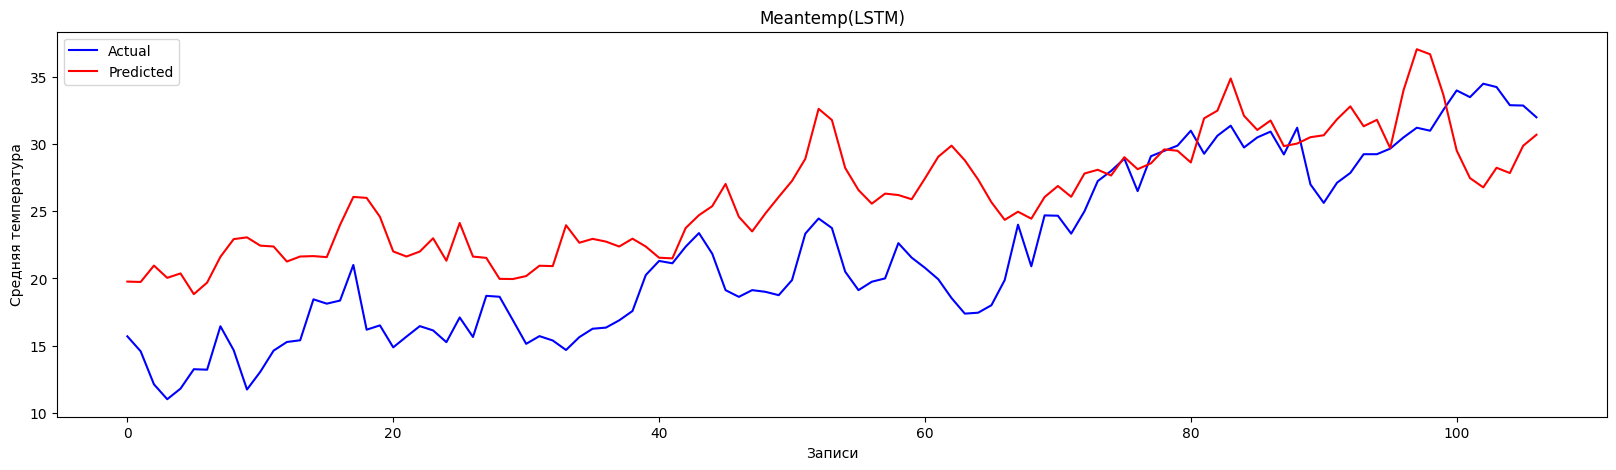

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(y_test_original, label='Actual', color = 'blue' )
plt.plot(predictions_original, label='Predicted', color = 'red')
plt.title('Meantemp(LSTM)')
plt.xlabel('Записи')
plt.ylabel('Средняя температура')
plt.legend()
plt.show()

#### Humidity(LSTM)

In [ ]:
df_train_humidity = create_lag_1(df_train, 'humidity')
df_test_humidity = create_lag_1(df_test, 'humidity')

X_train, y_train, scaler_target_train  = custom_df(df_train_humidity,
                             'humidity',
                             ['meantemp', 'wind_speed', 'meanpressure', 'lag1'],
                            time_steps = 5)

X_test, y_test, scaler_target_test  = custom_df(df_test_humidity,
                             'humidity',
                             ['meantemp', 'wind_speed', 'meanpressure', 'lag1'],
                            time_steps = 5)

In [ ]:
model = Sequential()

model.add(LSTM(75, return_sequences=True, input_shape=(5, 4)))
model.add(LSTM(75, activation='tanh',return_sequences=True))
model.add(Dropout(0.4))
model.add(AttentionMechanism(return_sequences=True))  # Внимание после LSTM
model.add(LSTM(75, activation='tanh',return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=42, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
35/35 [==============================] - 5s 43ms/step - loss: 0.1251 - val_loss: 0.0629
Epoch 2/100
35/35 [==============================] - 1s 15ms/step - loss: 0.0422 - val_loss: 0.0681
Epoch 3/100
35/35 [==============================] - 1s 14ms/step - loss: 0.0367 - val_loss: 0.0535
Epoch 4/100
35/35 [==============================] - 1s 14ms/step - loss: 0.0306 - val_loss: 0.0362
Epoch 5/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0293 - val_loss: 0.0451
Epoch 6/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0298 - val_loss: 0.0326
Epoch 7/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0297 - val_loss: 0.0529
Epoch 8/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0302 - val_loss: 0.0394
Epoch 9/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0289 - val_loss: 0.0435
Epoch 10/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0295 - val_loss: 0.0246

In [ ]:
predictions = model.predict(X_test)

predictions_original = scaler_target_test .inverse_transform(predictions)
y_test_original = scaler_target_test .inverse_transform(y_test.reshape(-1, 1))

mape_rnn = mean_absolute_percentage_error(y_test_original, predictions_original)
mae_rnn = mean_absolute_error(y_test_original, predictions_original)
print(f"MAPE: {mape_rnn}%")
print(f"MAE: {mae_rnn}")

4/4 [==============================] - 1s 8ms/step
MAPE: 19.670540491239443%
MAE: 8.795975998310857


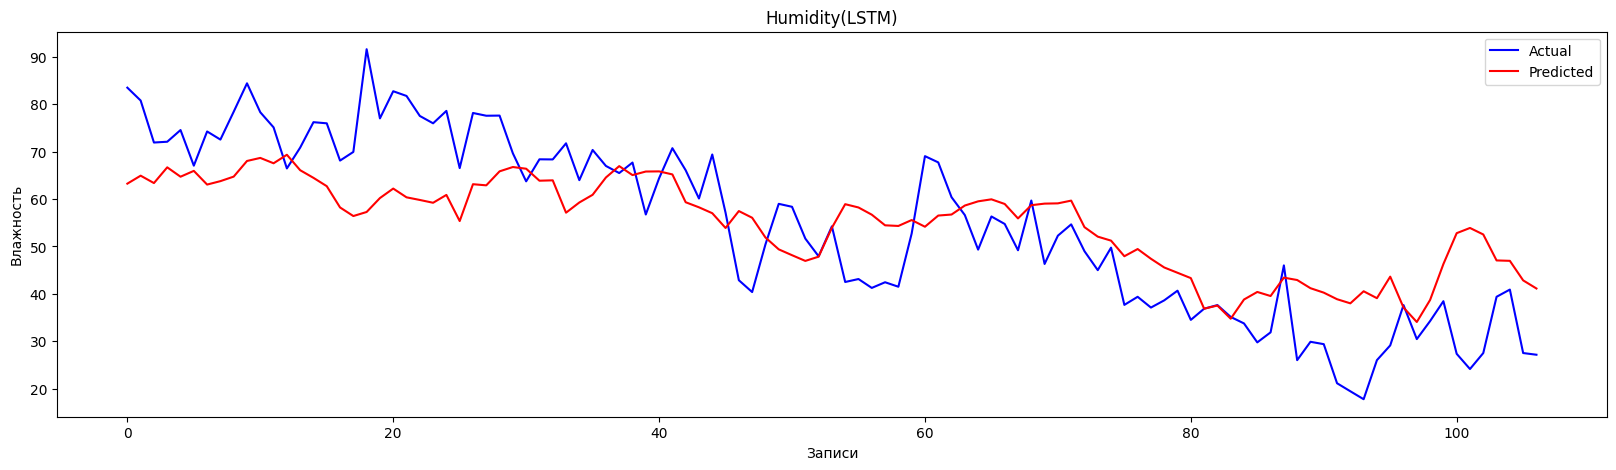

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(y_test_original, label='Actual', color = 'blue' )
plt.plot(predictions_original, label='Predicted', color = 'red')
plt.title('Humidity(LSTM)')
plt.xlabel('Записи')
plt.ylabel('Влажность')
plt.legend()
plt.show()

#### Wind_speed(LSTM)

In [ ]:
df_train_wind_speed = create_lag_1(df_train, 'wind_speed')
df_test_wind_speed = create_lag_1(df_test, 'wind_speed')

X_train, y_train, scaler_target_train  = custom_df(df_train_wind_speed,
                             'wind_speed',
                             ['meantemp', 'humidity', 'meanpressure', 'lag1'],
                            time_steps = 5)

X_test, y_test, scaler_target_test  = custom_df(df_test_wind_speed,
                             'wind_speed',
                             ['meantemp', 'humidity', 'meanpressure', 'lag1'],
                            time_steps = 5)

In [ ]:
model = Sequential()

model.add(LSTM(75, return_sequences=True, input_shape=(5, 4)))
model.add(LSTM(75, activation='tanh',return_sequences=True))
model.add(Dropout(0.4))
model.add(AttentionMechanism(return_sequences=True))  # Внимание после LSTM
model.add(LSTM(75, activation='tanh',return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=42, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
35/35 [==============================] - 5s 43ms/step - loss: 0.0154 - val_loss: 0.0875
Epoch 2/100
35/35 [==============================] - 1s 15ms/step - loss: 0.0112 - val_loss: 0.0884
Epoch 3/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0109 - val_loss: 0.0901
Epoch 4/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0110 - val_loss: 0.0990
Epoch 5/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0109 - val_loss: 0.0905
Epoch 6/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0109 - val_loss: 0.0908
Epoch 7/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0109 - val_loss: 0.0867
Epoch 8/100
35/35 [==============================] - 0s 14ms/step - loss: 0.0109 - val_loss: 0.0842
Epoch 9/100
35/35 [==============================] - 1s 15ms/step - loss: 0.0109 - val_loss: 0.0907
Epoch 10/100
35/35 [==============================] - 1s 15ms/step - loss: 0.0109 - val_loss: 0.0979

In [ ]:
predictions = model.predict(X_test)

predictions_original = scaler_target_test .inverse_transform(predictions)
y_test_original = scaler_target_test .inverse_transform(y_test.reshape(-1, 1))

mape_rnn = mean_absolute_percentage_error(y_test_original, predictions_original)
mae_rnn = mean_absolute_error(y_test_original, predictions_original)
print(f"MAPE: {mape_rnn}%")
print(f"MAE: {mae_rnn}")

4/4 [==============================] - 1s 6ms/step
MAPE: 47.95300934233345%
MAE: 4.136045273139559


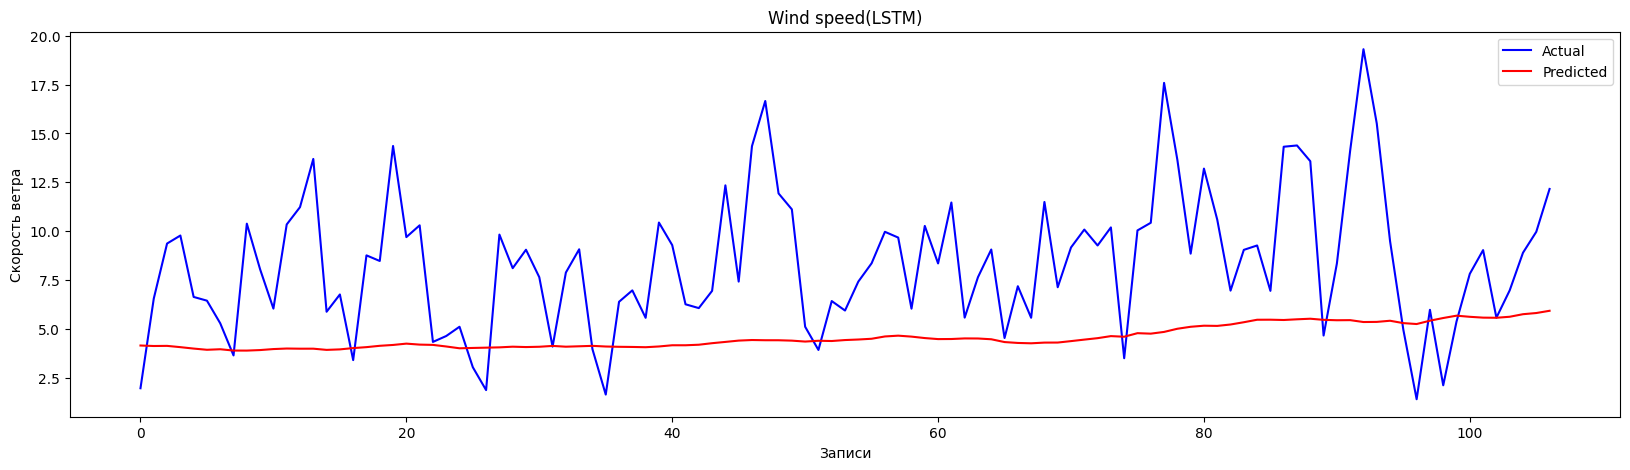

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(y_test_original, label='Actual', color = 'blue' )
plt.plot(predictions_original, label='Predicted', color = 'red')
plt.title('Wind speed(LSTM)')
plt.xlabel('Записи')
plt.ylabel('Скорость ветра')
plt.legend()
plt.show()

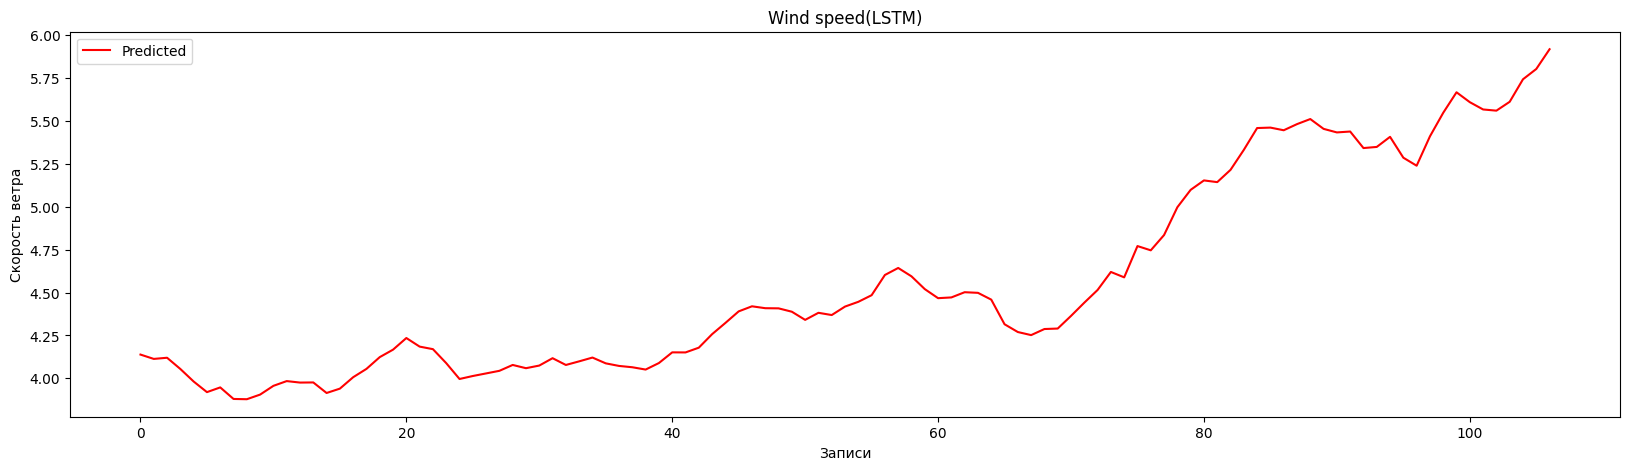

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(predictions_original, label='Predicted', color = 'red')
plt.title('Wind speed(LSTM)')
plt.xlabel('Записи')
plt.ylabel('Скорость ветра')
plt.legend()
plt.show()

#### Meanpressure(LSTM)

In [ ]:
df_train_meanpressure = create_lag_1(df_train, 'meanpressure')
df_test_meanpressure = create_lag_1(df_test, 'meanpressure')

X_train, y_train, scaler_target_train  = custom_df(df_train_meanpressure,
                             'meanpressure',
                             ['meantemp', 'humidity', 'wind_speed', 'lag1'],
                            time_steps = 5)

X_test, y_test, scaler_target_test  = custom_df(df_test_meanpressure,
                             'meanpressure',
                             ['meantemp', 'humidity', 'wind_speed', 'lag1'],
                            time_steps = 5)

In [ ]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(5, 4)))
model.add(LSTM(75, activation='tanh',return_sequences=True))
model.add(Dropout(0.4))
model.add(AttentionMechanism(return_sequences=True))  # Внимание после LSTM
model.add(LSTM(50, activation='tanh',return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)

model.fit(X_train, y_train, epochs=200, batch_size=42, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/200
35/35 [==============================] - 5s 41ms/step - loss: 0.0030 - val_loss: 0.2512
Epoch 2/200
35/35 [==============================] - 1s 19ms/step - loss: 5.8570e-04 - val_loss: 0.2461
Epoch 3/200
35/35 [==============================] - 1s 15ms/step - loss: 5.7275e-04 - val_loss: 0.2484
Epoch 4/200
35/35 [==============================] - 1s 15ms/step - loss: 5.7759e-04 - val_loss: 0.2478
Epoch 5/200
35/35 [==============================] - 1s 15ms/step - loss: 5.6903e-04 - val_loss: 0.2418
Epoch 6/200
35/35 [==============================] - 0s 14ms/step - loss: 5.6902e-04 - val_loss: 0.2466
Epoch 7/200
35/35 [==============================] - 1s 15ms/step - loss: 5.6160e-04 - val_loss: 0.2463
Epoch 8/200
35/35 [==============================] - 0s 14ms/step - loss: 5.6822e-04 - val_loss: 0.2437
Epoch 9/200
35/35 [==============================] - 1s 15ms/step - loss: 5.6049e-04 - val_loss: 0.2431
Epoch 10/200
35/35 [==============================] - 0s 14ms/step -

In [ ]:
predictions = model.predict(X_test)

predictions_original = scaler_target_test .inverse_transform(predictions)
y_test_original = scaler_target_test .inverse_transform(y_test.reshape(-1, 1))

mape_rnn = mean_absolute_percentage_error(y_test_original, predictions_original)
mae_rnn = mean_absolute_error(y_test_original, predictions_original)
print(f"MAPE: {mape_rnn}%")
print(f"MAE: {mae_rnn}")

4/4 [==============================] - 1s 6ms/step
MAPE: 1.0198174178860642%
MAE: 10.354085442594075


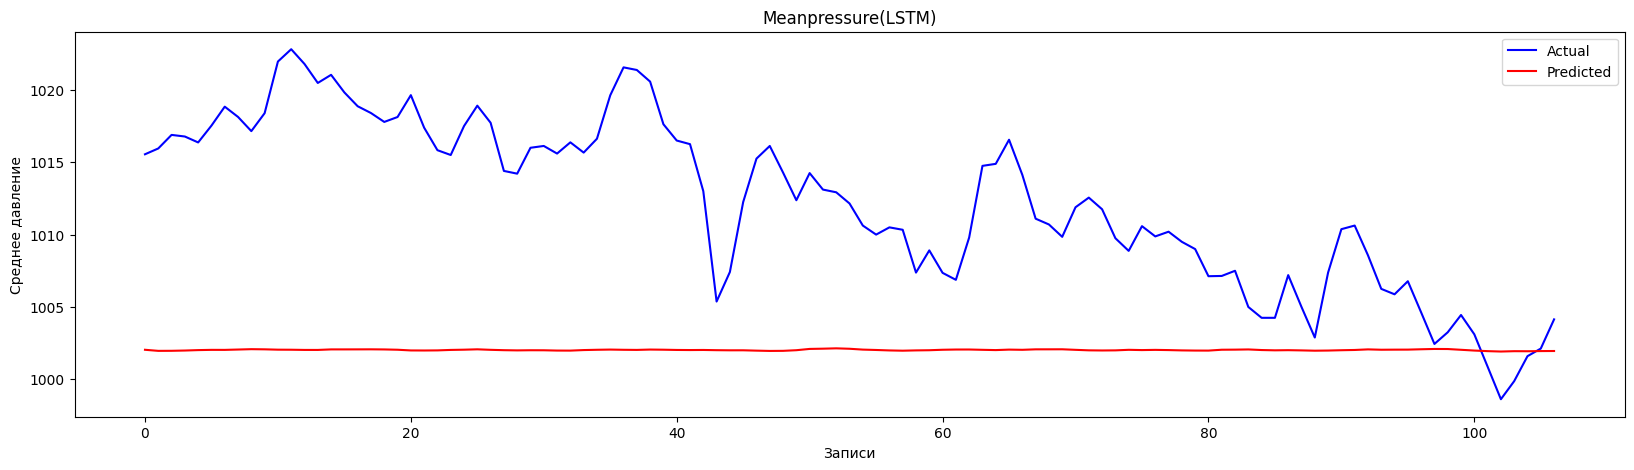

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(y_test_original, label='Actual', color = 'blue' )
plt.plot(predictions_original, label='Predicted', color = 'red')
plt.title('Meanpressure(LSTM)')
plt.xlabel('Записи')
plt.ylabel('Среднее давление')
plt.legend()
plt.show()

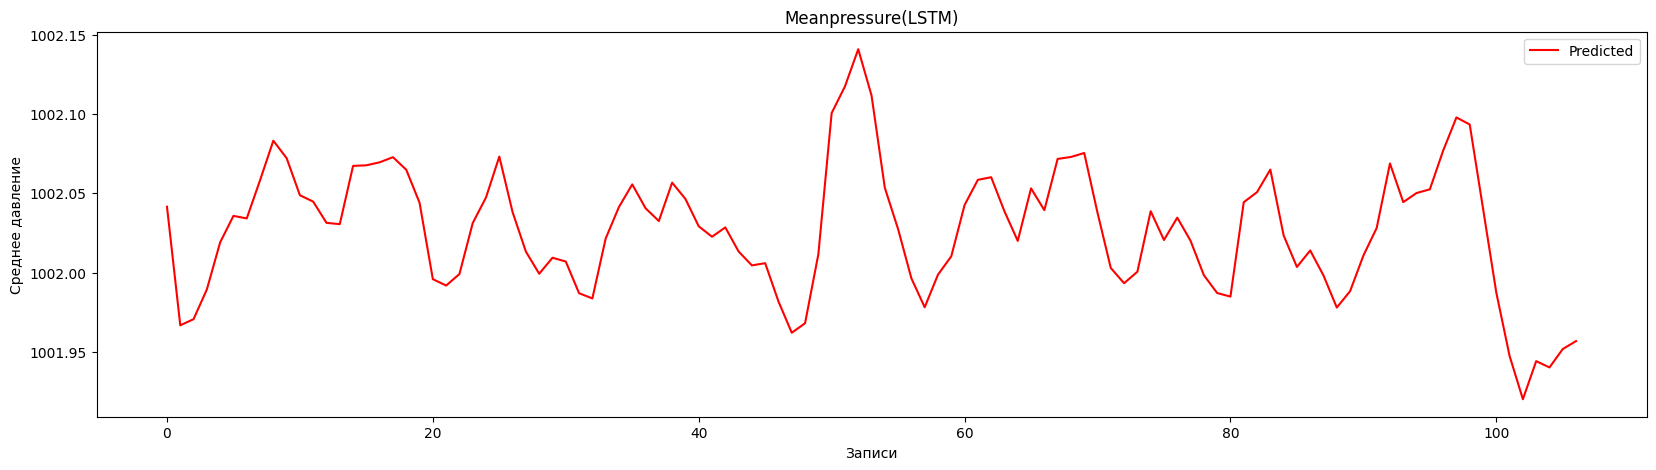

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(predictions_original, label='Predicted', color = 'red')
plt.title('Meanpressure(LSTM)')
plt.xlabel('Записи')
plt.ylabel('Среднее давление')
plt.legend()
plt.show()